# Building a Roberta-classifier


In this notebook we build a model to classify sentences. The classifier consists of a fully connected layer ont top of a RoBERTa model.

The implemenation is based on:
- https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
-https://huggingface.co/transformers/model_doc/bert.html
-https://huggingface.co/transformers/model_doc/roberta.html


## Loading all needed Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/RoBertaCola"

/content/drive/MyDrive/RoBertaCola


In [ ]:
! pip install transformers==3
! pip install tokenizers
! pip install --upgrade pandas

     |████████████████████████████████| 757kB 7.8MB/s 
     |████████████████████████████████| 1.2MB 38.3MB/s 
     |████████████████████████████████| 901kB 42.3MB/s 
     |████████████████████████████████| 3.0MB 46.6MB/s 
     |████████████████████████████████| 9.9MB 9.3MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.5 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


In [ ]:
import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from google.colab import drive
import random
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
#drive.mount('/content/gdrive')

- Get GPU

In [ ]:
# Get Device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Used device is {device}')

Used device is cuda:0


## Loading and Combining Data into Dataset

In this section the data is supposed to be laoded. Here we should have two lists of sentences, each from one corpus. These will be assigned labels and  then grouped and shuffled. Make sure the data is at least to some extend balanced.

In [ ]:
# Validation data
data_train = pd.read_csv("data/in_domain_train.tsv", sep="\t", names = ["code","label", "orig_label", "sentence"])
data_train_2 = pd.read_csv("data/in_domain_dev.tsv", sep="\t", names = ["code","label", "orig_label", "sentence"])
data_train_3 = pd.read_csv("data/out_of_domain_dev.tsv", sep="\t", names = ["code","label", "orig_label", "sentence"])
data_t = pd.concat([data_train, data_train_2,data_train_3]).reset_index(drop = True)


# balance 40/60
#label1 = data_t[data_t.label == 1].sample(4278)
#label2 = data_t[data_t.label == 0]
#data_t = label1.append(label2)
#print(data_t.label.value_counts())
#data_t.label.hist()


data = tuple(data_t.sentence)
labels = tuple(data_t.label)

## Building RoBERTa Classifier Model
Here we use the classical RoBERTa model 'roberta-base'. This might be replaced by more specific pretrained models. 

### Bert specific processing

In [ ]:
# Special RoBERTa mdoe to be used: While slight information might be lost; capitalization in tweets is a neglectable characteristic
PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

- Get understanding of the distribution of token sizes for maximal length used in BERT

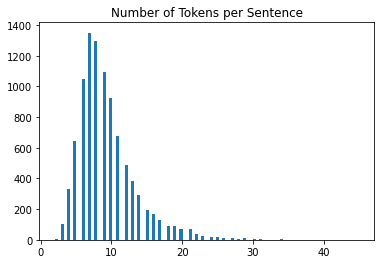

In [ ]:
# Using actual data
len_data = [len(tokenizer.tokenize(t)) for t in data]
plt.hist(len_data, bins = 100)
plt.title('Number of Tokens per Sentence')
plt.show()

### Build PyTorch Dataset and DataLoader

In [ ]:
# Data Structure
class SentenceDataset(Dataset):
    def __init__(self, sents, labels, tokenizer, max_len):
        self.sents = sents
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sents)
    
    def __getitem__(self, item):
        
        sent = str(self.sents[item])
        label = self.labels[item]

        encoding = tokenizer(sent,
                             truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = 'max_length',
                             max_length=self.max_len,
                             return_attention_mask=True,
                             return_tensors='pt')
      
        return { 'sent': sent, 'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
        }
# Data Loader
def create_data_loader(sentences, labels, tokenizer, max_len, batch_size):
    ds = SentenceDataset(
        sents=sentences, #.to_numpy()
        labels=labels, #.to_numpy()
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

### Actual Model

In [ ]:
class StyleClassifier(nn.Module):
    def __init__(self, n_classes, drop = 0.3):
        
        super(StyleClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=drop)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

## Training the model

### Define Helper functions

In [ ]:
# This provides just a way to illustrate our confusion matrices in a nice and labeled way
def show_confusion_matrix(confusion_matrix, names = ['Scientific', 'Non-Scientifc'], save_path = None):
  confusion_df = pd.DataFrame(cm, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)
  if save_path:
    plt.savefig(save_path)
  plt.show()

In [ ]:
def get_predictions(model, data_loader):
  # put to eval mode to disable dropout 
  model = model.eval()

  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask) #dim BATCH_SIZE x 3
      # torch.max(outputs, dim=1) returns (vals, positions) of maxima -> positions are kept and correspond to class labels
      _, preds = torch.max(outputs, dim=1) # dim BATCH_SIZE x 1

      predictions.extend(preds)
      #prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  #prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values #prediction_probs

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    model = model.train()
    losses = []
    correct_predictions = 0
    
    show_every = np.floor(len(data_loader)/5)
    
    for i,d in enumerate(data_loader):
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # torch.max(outputs, dim=1) returns (vals, positions) of maxima -> positions are kept and correspond to class labels
        _, preds = torch.max(outputs, dim=1)
        
        loss = loss_fn(outputs, labels) # both outputs and labels are in {0,1,2}
        correct_predictions += torch.sum(preds == labels)
        
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
                
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

### Parameter choices
- Set hyper parameters and run optimization accordingly

In [ ]:
MAX_LEN = 30 # chosen acccroding to hist above
BATCH_SIZE = 64# tunable hyper parameter
EPOCHS = 10
lr = 1e-6
dropout = 0.5

# Choose adequate paths to google drive
model_save_path = "BERT_training_data/model_balanced6.pt"# save model parameters, should include BERT and hyperparameters in name
#img_save_path = "stats/test.png" # save confusion matrix, should include BERT and hyperparameters in name
report_save_path = "stats/report_balanced.csv" # save classification report, should include BERT and hyperparameters in name

### Optimization


- Prepare data

In [ ]:
# Splitting data -> adpat split if necessary
data_train, data_valtest, labels_train, labels_valtest = train_test_split(data, labels, test_size=0.1, random_state = 42) 
data_val, data_test, labels_val, labels_test = train_test_split(data_valtest, labels_valtest, test_size=0.5,random_state = 42) 

assert len(data) == len(data_test)+len(data_train)+len(data_val)

print(f'Number of training sentences: \t {len(data_train)}')
print(f'Number of validation sentences:  {len(data_val)}')
print(f'Number of test sentences: \t {len(data_test)}')

# Create DataLoaders
train_data_loader = create_data_loader(data_train, labels_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(data_val, labels_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, labels_test, tokenizer, MAX_LEN, BATCH_SIZE)

Number of training sentences: 	 8634
Number of validation sentences:  480
Number of test sentences: 	 480


- Initialize model


In [ ]:
# Initialize model
# give number of classes 
model = StyleClassifier(2, drop = dropout).to(device)

- Set everything optimization related



In [ ]:
#Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps= len(train_data_loader) * EPOCHS
)


# The choice of loss is done, as 'This criterion combines LogSoftmax and NLLLoss in one single class'. 
# given input vector softmay is applied, and then NLLL  loss performed

class_weights=compute_class_weight('balanced',np.unique(labels),np.array(labels))
#class_weights = class_weights + np.array([1,0])
class_weights=torch.tensor(class_weights,dtype=torch.float)

loss_fn = nn.CrossEntropyLoss(weight = class_weights).to(device)

In [ ]:
class_weights

tensor([1., 1.])

- Actual optimization procedure

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(data_train))
      
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(data_val))
      
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        if model_save_path:
          print(f'Model updated after epoch: {epoch+1} \n')
          torch.save(model.state_dict(), model_save_path)
        best_accuracy = val_acc


Epoch 1/10
----------
Train loss 0.6978817869115759 accuracy 0.49620105201636466
Val   loss 0.6881073355674744 accuracy 0.6771929824561403

Model updated after epoch: 1 

Epoch 2/10
----------
Train loss 0.6806976581797187 accuracy 0.5673095655562049
Val   loss 0.6570289134979248 accuracy 0.6771929824561403

Epoch 3/10
----------
Train loss 0.6125710290155293 accuracy 0.690239625949737
Val   loss 0.5724157691001892 accuracy 0.7403508771929824

Model updated after epoch: 3 

Epoch 4/10
----------
Train loss 0.5405774337274057 accuracy 0.7492694330800701
Val   loss 0.5346476972103119 accuracy 0.775438596491228

Model updated after epoch: 4 

Epoch 5/10
----------
Train loss 0.5026210896026941 accuracy 0.7740112994350282
Val   loss 0.5250301241874695 accuracy 0.775438596491228

Epoch 6/10
----------
Train loss 0.48512140725865777 accuracy 0.7888174556789401
Val   loss 0.5058772563934326 accuracy 0.7894736842105263

Model updated after epoch: 6 

Epoch 7/10
----------
Train loss 0.47287759

## Model Evaluation

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
#plt.yscale('log')
plt.show()

- Next we load our best model, as the current state might have overfitted

In [ ]:
# load best model from optimization
if model_save_path: 
  model = StyleClassifier(2)
  #model.load_state_dict(torch.load("BERT_training_data/model_RoBerta.pt"))
  model.load_state_dict(torch.load("BERT_training_data/model_balanced3.pt"))
  model = model.to(device)

In [ ]:
# Test Accuracy
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(data_test))
print(f'Test Accuracy: {test_acc.item()}')

Test Accuracy: 0.86875


- Calculate Scores 

In [ ]:
# Calculation of relevant scores
labels_pred, labels_test = get_predictions(model, test_data_loader)
report = classification_report(labels_test, labels_pred, target_names=['0', '1'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
#if report_save_path:
#  report_df.to_csv(report_save_path) 

print(report_df)

              precision    recall  f1-score    support
0              0.790323  0.725926  0.756757  135.00000
1              0.896067  0.924638  0.910128  345.00000
accuracy       0.868750  0.868750  0.868750    0.86875
macro avg      0.843195  0.825282  0.833443  480.00000
weighted avg   0.866327  0.868750  0.866993  480.00000


In [ ]:
labels_pred, labels_test = get_predictions(model, test_data_loader)

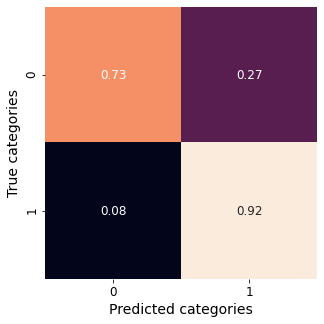

In [ ]:
cm = confusion_matrix(labels_test, labels_pred, normalize = 'true')
show_confusion_matrix(cm, names = ["0","1"])

## Predict new data

In [ ]:
import pandas as pd

In [ ]:
gpt2_sents = pd.read_excel("gpt2_final_stats-1.xlsx")
t5_p2_sents = pd.read_excel("t5_p2_final_stats.xlsx")
t5_p3_sents = pd.read_excel("t5_p3_final_stats.xlsx")
ev_sample = pd.read_excel("evaluation_sample3000(1).xlsx")

In [ ]:
filtered_sentences = gpt2_sents.paraphrased_sent

In [ ]:
filtered_sentences = ev_sample.sent
labels_testing = [1] * len(filtered_sentences)
sent_data_loader = create_data_loader(filtered_sentences, labels_testing, tokenizer, MAX_LEN, BATCH_SIZE)
pred_ev, true_value = get_predictions(model, sent_data_loader)


def predict_sents(input):
  filtered_sentences = input
  labels_testing = [1] * len(filtered_sentences)
  sent_data_loader = create_data_loader(filtered_sentences, labels_testing, tokenizer, MAX_LEN, BATCH_SIZE)
  pred_gpt, true_value = get_predictions(model, sent_data_loader)

  df = pd.DataFrame(list(filtered_sentences), columns = ["sent"])
  df["label"] = pred_gpt
  df["orig_sent"] = ev_sample.sent
  df["orig_label"] = pred_ev
  return df


In [ ]:
df_gpt = predict_sents(gpt2_sents.paraphrased_sent)
df_t5_p2 = predict_sents(t5_p2_sents.paraphrased_sent)
df_t5_p3 = predict_sents(t5_p3_sents.paraphrased_sent)